In [1]:
%matplotlib inline

In [2]:
from glob import glob
import json
import pydicom
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from utils import load_df_with_labels_and_dicom_tags

DISEASES = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

df = load_df_with_labels_and_dicom_tags()

# Table of contents

1. [ Data preprocessing ](#preprocessing)
2. [ General statistics ](#general)
3. [ Lables ](#labels)
4. [ Dicom tags ](#tags)



<a name="preprocessing"></a>
# Data preprocessing

### Drop columns with constant values

In [3]:
names = {}
for column in df.columns:
    try:
        unique_values = df[column].unique()
        if len(unique_values) == 1:
            names[column] = unique_values[0]
    except:
        pass

df = df.drop(columns=names.keys())
print(names)

{'Modality': 'CT', 'StudyID': '', 'SamplesPerPixel': 1, 'PhotometricInterpretation': 'MONOCHROME2', 'BitsAllocated': 16, 'RescaleSlope': 1.0}


In [4]:
df.head()

,SOPInstanceUID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,PatientID,StudyInstanceUID,SeriesInstanceUID,...,Columns,PixelSpacing,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,path,subset
0,ID_000039fa0,0.0,0.0,0.0,0.0,0.0,0.0,ID_eeaf99e7,ID_134d398b61,ID_5f8484c3e0,...,512,"[0.488281, 0.488281]",16,15,1,30,80,-1024.0,/kolos/storage/ct/data/rsna/stage_1_train_imag...,train
1,ID_00005679d,0.0,0.0,0.0,0.0,0.0,0.0,ID_18f2d431,ID_b5c26cda09,ID_203cd6ec46,...,512,"[0.460938, 0.460938]",16,15,1,50,100,-1024.0,/kolos/storage/ct/data/rsna/stage_1_train_imag...,train
2,ID_00008ce3c,0.0,0.0,0.0,0.0,0.0,0.0,ID_ce8a3cd2,ID_974735bf79,ID_3780d48b28,...,512,"[0.48828125, 0.48828125]",12,11,0,"[00040, 00040]","[00080, 00080]",-1024.0,/kolos/storage/ct/data/rsna/stage_1_train_imag...,train
3,ID_0000950d7,0.0,0.0,0.0,0.0,0.0,0.0,ID_d278c67b,ID_8881b1c4b1,ID_84296c3845,...,512,"[0.494863, 0.494863]",16,15,1,35,135,-1024.0,/kolos/storage/ct/data/rsna/stage_1_train_imag...,train
4,ID_0000aee4b,0.0,0.0,0.0,0.0,0.0,0.0,ID_ce5f0b6c,ID_9aad90e421,ID_1e59488a44,...,512,"[0.423828125, 0.423828125]",12,11,0,"[00036, 00036]","[00080, 00080]",-1024.0,/kolos/storage/ct/data/rsna/stage_1_train_imag...,train


In [6]:
df.columns

Index(['SOPInstanceUID', 'any', 'epidural', 'intraparenchymal',
       'intraventricular', 'subarachnoid', 'subdural', 'PatientID',
       'StudyInstanceUID', 'SeriesInstanceUID', 'ImagePositionPatient',
       'ImageOrientationPatient', 'Rows', 'Columns', 'PixelSpacing',
       'BitsStored', 'HighBit', 'PixelRepresentation', 'WindowCenter',
       'WindowWidth', 'RescaleIntercept', 'path', 'subset'],
      dtype='object')

# General statistics:

### Number of patients

In [6]:
len(df.PatientID.unique())

18938

### Number of studies

In [7]:
len(df.StudyInstanceUID.unique())

21744

### Number of series

In [9]:
len(df.SeriesInstanceUID.unique())

21744

### Number fo slices

In [8]:
len(df.SOPInstanceUID.unique())

752803

### Split proportions

In [7]:
scans_num = len(df.groupby(['SeriesInstanceUID']))
scans_train_num = len(df[df.subset == "train"].groupby(['SeriesInstanceUID']))
scans_test_num = len(df[df.subset == "test"].groupby(['SeriesInstanceUID']))

print("Total number of scans: {} (train/test: {}/{}, {:.3f}/{:.3f})".format(
    scans_num, scans_train_num, scans_test_num, 
    scans_train_num / scans_num,
    scans_test_num / scans_num
))

slices_num = len(df)
slices_train_num =  len(df[df.subset == "train"])
slices_test_num =  len(df[df.subset == "test"])

print("Total number of slices: {} (train/test: {}/{}, {:.3f}/{:.3f})".format(
    slices_num, slices_train_num, slices_test_num,
    slices_train_num / slices_num, 
    slices_test_num / slices_num
))


Total number of scans: 21744 (train/test: 19530/2214, 0.898/0.102)
Total number of slices: 752803 (train/test: 674258/78545, 0.896/0.104)


The distribution of slices between scans for training split and test split is similar.

# Labels

### Positive samples for full scans

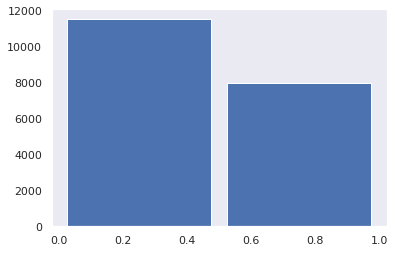

In [8]:
series = df[df.subset == "train"].groupby(['SeriesInstanceUID']).agg({"any": "sum"})
series['is_positive'] = (series["any"] > 0).astype('int32')

series.is_positive.hist(bins=2, rwidth=0.9, grid=False)


### Positive samples for slices

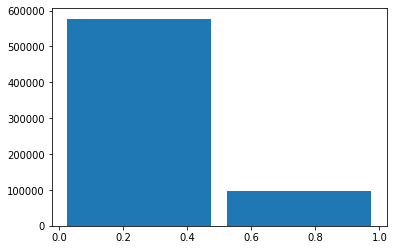

In [5]:
df[df.subset == "train"]["any"].hist(bins=2, rwidth=0.9, grid=False)

### Class distribution for slices

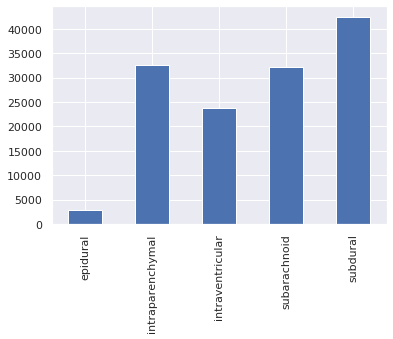

In [16]:
df[DISEASES].dropna().sum().plot(kind='bar')

# Class distribution for scans

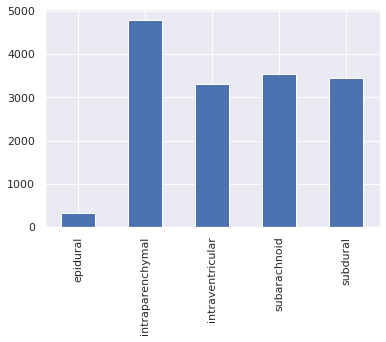

In [10]:
series = df.groupby(['SeriesInstanceUID'])[DISEASES].sum()
(series > 0).astype('int32').sum().plot(kind='bar')

# Outliers

### Shapes different than 512x512

In [75]:
print(df[df.Columns != 512].Columns.unique())
print(df[df.Columns != 512].Rows.unique())

[464 374 490 462 404 768 436]
[464 408 638 462 430 768 436]


### Scan ids with shape unequal to 512x512

In [86]:
list(df[(df.Columns != 512) | (df.Rows != 512)].SeriesInstanceUID.unique())

['ID_0deb2f6b3a',
 'ID_75cdc73883',
 'ID_4d75f19cd0',
 'ID_fa19cd5ea9',
 'ID_44c08b8355',
 'ID_e32965796b',
 'ID_9224996075',
 'ID_c04681e848']

In [87]:
df[(df.Columns != 512) | (df.Rows != 512)].subset.unique()

array(['train'], dtype=object)

Slices with unregular shape belong only to train subset.

# PixelSpacing

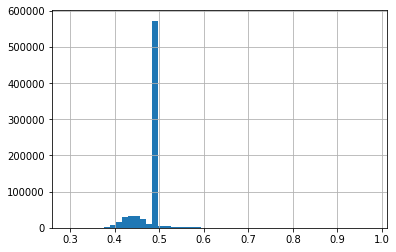

In [91]:
spacing = pd.DataFrame(df.PixelSpacing.values.tolist(), columns=['x','y'])
len(spacing[spacing.x != spacing.y])
spacing.x.hist(bins=50)

# Correlation between diseases

In [10]:
df[DISEASES].corr().style.background_gradient(cmap='Blues')

,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
epidural,1,0.045785,0.014947,0.0384301,0.0450118
intraparenchymal,0.045785,1,0.317677,0.219859,0.127778
intraventricular,0.014947,0.317677,1,0.211551,0.0630849
subarachnoid,0.0384301,0.219859,0.211551,1,0.185681
subdural,0.0450118,0.127778,0.0630849,0.185681,1


# Gantry tilt
* [Gantry Tilt explanation (search for "Figure 1")](https://www.frontiersin.org/articles/10.3389/fninf.2019.00061/full)
* [Patient Orientation](http://dicomiseasy.blogspot.com/2013/06/getting-oriented-using-image-plane.html)

In [33]:
def print_gantry_tilt_fraction(split_name):
    orientations = np.array(df[df.subset == split_name].groupby(
        ['SeriesInstanceUID']).first().ImageOrientationPatient.to_list())
    
    gt_fraction = len(orientations[orientations[:, 4] != 1]) / len(orientations) * 100
    print("{:.4}%".format(gt_fraction))

### Number of samples with gantry tilt in train subset

In [34]:
print_gantry_tilt_fraction('train')

53.23%


### Number of samples with gantry tilt in test subset

In [35]:
print_gantry_tilt_fraction('test')

91.55%


In [ ]:
# sprawdzić windows,
# podział na train/test wszędzie
# spadać outliery w rozmiarach i w gantry tilt
# sprawidzic ile patients id się powtarza
# 
